# Fatal Police Shootings in the US #

## 1. Introduction

In the years 2015, 2016, and 2017 there were 2945 people involved in a fatal police shooting in the United states according to [The Washington Post](https://www.washingtonpost.com/graphics/national/police-shootings/).  
Where we have 995 people killed in 2015, 963 people killed in 2016, and 987 people killed in 2017. As we can see from those numbers there is little change from years in police fatal shootings.  
In this report we will dive deeper into this, and try to answer the question in which state it is best to live in to avoid fatal police shootings.

## 2. About

### 2.1 Data
The data used for measurement is recieved from kaggle [fatal police shootings in the us](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/version/1)  
This source includes data about police shootings in the United States but also has an additional information regarding various information about the incident. The dataset also contains information about the city the incident occurred in, such as median income, percentages of how many completed high school and race division  of the cities.

## 3. Preparing the data

### 3.2 Import the necessary libraries

In [57]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

### 3.3 Import the data sets

In [2]:
# Read the datasets
shootings_df = pd.read_csv('resources/PoliceKillingsUS.csv',encoding="windows-1252",parse_dates=[2])
medianIncome_df = pd.read_csv('resources/MedianHouseholdIncome2015.csv',encoding="windows-1252")
povertyLevel_df = pd.read_csv('resources/PercentagePeopleBelowPovertyLevel.csv',encoding="windows-1252")
completedHighschool_df = pd.read_csv('resources/PercentOver25CompletedHighSchool.csv',encoding="windows-1252")
race_distribution_df = pd.read_csv('resources/raceByUS.csv', encoding="utf-8")
population_by_state_df = pd.read_csv('resources/state_population.csv')

### 3.4 Basic cleaning of the data

In [3]:
# Shootings_df

# We have no use for the id and name of the person columns so we decided to remove them
shootings_df = shootings_df.drop(['id','name'], axis=1)

# MedianIncome_df
# There are some values with '-' or '(x)' in them, so we remove them
medianIncome_df['Median Income'] = medianIncome_df['Median Income'].apply(lambda x : x if str(x).isdigit() else None)
medianIncome_df.dropna(inplace=True)

## 4. Where is the best and worst place to live according to fatal police shootings

In this section we will take a look at the datasets we have and dive into various interesting questions where we work our way to answering the main question where to live to avoid fatal police shootings

### 4.1 Answering the question using the shootings data

In this section we will only be using the shootings data to answer interesting questions about fatal police shootings incidents, which as you can see in the table below has information
about how many were killed in fatal police shootings, as well as additional information such as age, gender, 
race, the state it took place,if the suspect was armed and more. 

In [4]:
shootings_df.head(10)

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,2015-02-01,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,2015-02-01,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,2015-03-01,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,2015-04-01,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,2015-04-01,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
5,2015-04-01,shot,gun,18.0,M,W,Guthrie,OK,False,attack,Not fleeing,False
6,2015-05-01,shot,gun,22.0,M,H,Chandler,AZ,False,attack,Car,False
7,2015-06-01,shot,gun,35.0,M,W,Assaria,KS,False,attack,Not fleeing,False
8,2015-06-01,shot,unarmed,34.0,F,W,Burlington,IA,False,other,Not fleeing,True
9,2015-06-01,shot,toy weapon,47.0,M,B,Knoxville,PA,False,attack,Not fleeing,False


### 4.2 Interesting questions using the dataframe

Here below we will ask interesting questions and answering them in a visual way, the questions are: 
* How are the shootings divided by race?
* Is it more likely that the victim was unarmed if the officer has a bodycamera?
* Is it more likely to be shot if you are a man?
* What state has the most fatal police shootings?


#### 4.2.1 Divison of races

For the last five years an international activist [black lives matter](https://en.wikipedia.org/wiki/Black_Lives_Matter) movement have gained alot of attention through social media platforms and the news. This movement campains against violence and systemic racistm towards black people.
In this chapter we will take a closer look at the divison of races in the United States regarding fatal police shootings.


To show the difference between the races that are killed in police shootings from the data set we have decided to plot a pie chart which shows the percentages of each race involved in fatal police shootings.     

The race in the shootings dataset sometimes contains other as a race value, which has no meaning to us. Therefor we will remove the row that contains other as a race before we start working the dataset.

In [5]:
# Remove rows that contain Other in the race column
shootings_race_df = shootings_df[shootings_df.race != 'O']
# Print how many rows we had to remove
print('Removed', shootings_df.shape[0]-shootings_race_df.shape[0],'rows containing other as a race')

Removed 28 rows containing other as a race


In [6]:
def raceLabelToRace(raceLabel):
    if(raceLabel == 'W'):
        return 'White'
    if(raceLabel == 'B'):
        return 'Black'
    if(raceLabel == 'N'):
        return 'Native American'
    if(raceLabel == 'A'):
        return 'Asian'
    if(raceLabel == 'H'):
        return 'Hispanic'

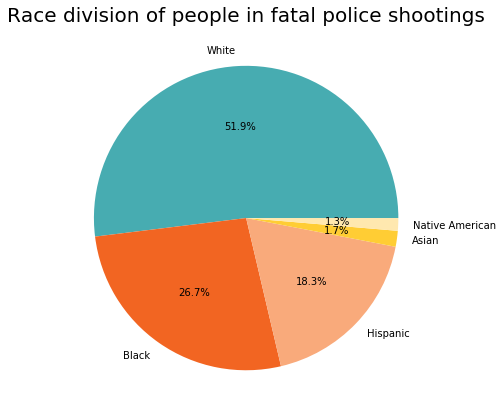

In [7]:
# Race rates  
labels = shootings_race_df['race'].value_counts().index
# Change the labels we have to words, for easier reading
labels = [raceLabelToRace(x) for x in labels]
colors = ['#47ACB1', '#F26522', '#F9AA7B', '#FFCD34','#FFE8AF']
values = shootings_race_df['race'].value_counts().values

# Plotting the pie chart
plt.figure(figsize = (7, 7))
plt.pie(values, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('Race division of people in fatal police shootings', color = 'black', size = 20)
plt.show()

As we can see from the pie chart above, the majority or 51,9% of races killed in police shootings are categorized as white. By looking only at this data we would assume that it is more likely for people with white skin to be involved in a fatal police shooting.  
Despite the results we can read from the pie chart above, it is unfair to assume that it is more likely that you are to fall victim of a fatal police shooting if you are white, since the majority of people living the United states have white skin.
According to [KFF Population Distribution by Race/Ethnicity](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) the race distribution in the United states can be seen in the table below.
We will then use this to get a more fair estimate of what race is more likely to be killed in a police shooting.

By looking at the average race division in the United States in the table below, 
we can see in the table below that 61% percentage of people living in the US are white



# TODO:::: BERA SAMAN US DISTRIBUTION VS POLICLE KILLING

In [8]:
race_distribution_df

,Location,White,Black,Hispanic,Asian,American Indian/Alaska Native,Native Hawaiian/Other Pacific Islander
0,United States,0.61,0.12,0.18,0.06,0.01,<.01


#### 4.2.2 Is it more likely that the victim was unarmed if the officer has a body camera?

In this chapter we will take a look at if it makes a difference whether it is logged that the victim was armed or not and if the police officers has a body camera or not, We will do so by looking at the variables armed and body_camera in the shootings data.

In [9]:
#shootings_df[(shootings_df['body_camera'] == False) & (shootings_df['armed'] == 'unarmed')].shape[0]
#shootings_df[shootings_df[(shootings_df['body_camera'] == False)& (shootings_df['armed'] == 'unarmed') / (shootings_df['body_camera'] == False)].shape[0]].shape[0])

#df = shootings_df.apply(lambda x : x if x['body_camera'] == True and x['armed'] == 'unarmed' else "", axis=1)
shootings_df[(shootings_df['body_camera'] == False)&(shootings_df['armed'] != 'unarmed')].shape

(2120, 12)

niðurstöður frá 4.2.2

#### 4.2.3 Is it more likely to be in a fatal police shooting if you are a man?

In this chapter we will take a look at if it makes a difference whether, and if you are more likely to be in a fatal police shooting if you are a man.
We will do so by taking a look at the distribution of the genders in the dataset of police shootings in the US, and displaying the results in a bar plot.

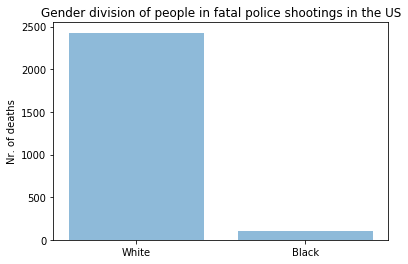

In [10]:
# Create the labels
Labels = ('Male','Female' )
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = shootings_df['gender'].value_counts().tolist()
# Create the bar plot
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Nr. of deaths')
plt.title('Gender division of people in fatal police shootings in the US')
 
plt.show()

As we can see from the bar plot above, the majority of people killed in police shootings are male, where the data shows us that there were around 2400 males and around 100 females killed.  
This shows us that it is much less likely to be killed in police shootings if you are a female than a male.


#### 4.2.4 Police shooting according to state

In each state the amount fatal police shootings is different and maybe more frequent in some states than others, therefor it is interesting to look at the distribution of how many were killed in each state.  
In this chapter we will take a look at police shooting rate according to each state, and visualize it using a bar plot.

51


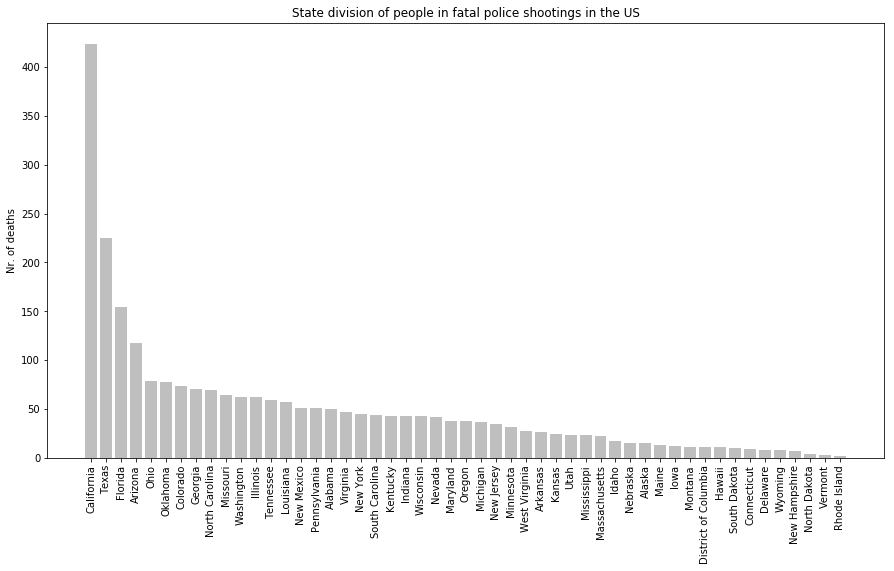

In [11]:
# Create a states dictionary to convert from abbreviations to full names of states
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}
# Change abbreviations of states to state names
states_shootings_df = shootings_df.state.apply(lambda x : states[x])
print(len(states_shootings_df.value_counts()))
# Create the labels
Labels = states_shootings_df.value_counts().index.tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = states_shootings_df.value_counts().tolist()
# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='gray')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Nr. of deaths')
plt.title('State division of people in fatal police shootings in the US')
 
plt.show()

As we can see in the bar plot above there is a huge difference in the amounts of deaths in police shootings depending on the state.
We can see that the state with the largest number of deaths by police shootings is with out a doubt the state of California, followed by Texas and the lowest number of deaths is in the  state of Rhode Island.

#### 4.2.5 Diving deeper into state divison of fatal police shootings

To make a fair estimate of what state has the most fatal police shootings according to population, we must take into account how many people live in each state, we can do so by looking up for each state how many live in that state. From there we can divide the number of fatal police shootings by population of each state to get the probability of being in a fatal accident with the police in each state.

In [12]:
# Create new df and change the state to real name of state
us_shootings_df = shootings_df
us_shootings_df['state'] = shootings_df.state.apply(lambda x : states[x])
# Create dictionary out of how many occurences we have in each state
StateOccurranceDict = dict(us_shootings_df['state'].value_counts())

In [13]:
# Remove the ',' in each population_estimate so we can calculate it
population_by_state_df['population_estimate'] = population_by_state_df['population_estimate'].str.replace(',', '')

# Create array to keep track of probability of being killed in police shooting for each state
prob_of_death_per_state = []

# Calculate the probability of being killed in each state
for index, row in population_by_state_df.iterrows():
    # if state is in dictionary calculate probability
    if(StateOccurranceDict[row['state']]):
        prob_of_death_per_state.append((row['state'],(float(StateOccurranceDict[row['state']])/float(row['population_estimate']))))
            

In [14]:
#Create dataframe from percentage calculations
states_prob_df = pd.DataFrame(prob_of_death_per_state, columns=['state', 'probability_of_fatal_shooting (%)'])  
# Format the probability column so it displays the result in human readable form
states_prob_df['probability_of_fatal_shooting (%)'] = states_prob_df['probability_of_fatal_shooting (%)'].apply(lambda x : "{:.5%}".format(x))
states_prob_df['probability_of_fatal_shooting (%)'] = states_prob_df['probability_of_fatal_shooting (%)'].apply(lambda x : x.replace('%',''))

In [15]:
result = states_prob_df.sort_values(by=['probability_of_fatal_shooting (%)'], ascending=True)
result.head(10)

,state,probability_of_fatal_shooting (%)
39,Rhode Island,0.00019
34,New York,0.00023
6,Connecticut,0.00025
19,Massachusetts,0.00032
22,Michigan,0.00037
12,Iowa,0.00038
31,New Jersey,0.00039
38,Pennsylvania,0.00040
46,Vermont,0.00048
14,Illinois,0.00049


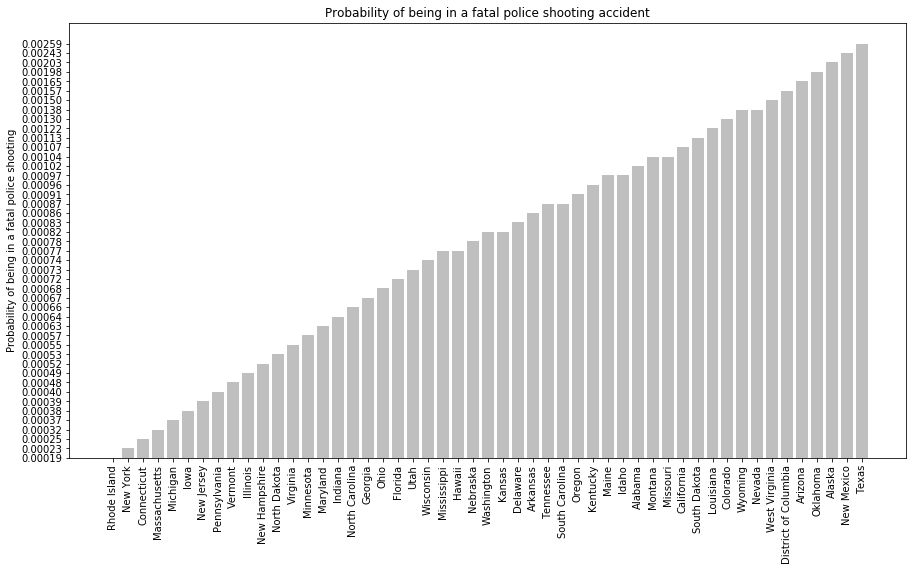

In [16]:
# Create the labels
Labels = result['state'].tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = result['probability_of_fatal_shooting (%)'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='grey')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Probability of being in a fatal police shooting')
plt.title('Probability of being in a fatal police shooting accident')
 
plt.show()

As we can see in the bar plot above after calculating the probability of being in a fatal police shooting accident by each state, the state with the highest probability of people killed is Texas with 0.00259% probabilities. The state with the lowest probability is Rhode Island with 0.00019% probabilities.
By comparing the two bar plots we can see there are alot of changes for some states, for example California in the previous bar plot had the highest number of people killed in police shootings, while it is now in 13'th place in the new bar plot which takes into account how many people live in the state.
Which shows us that the population matters alot when comparing which state has the lowest and highest fatal police shootings.

With the data we have now gone over we can see that the best place to live in to avoid police shooting is Rhode Island.

## 4.3 Answering the question using the median income data

Does it make a difference if the median income in a state is higher regarding to fatal police shootings?  
We will answer this question by taking a look at the median income of each states in the United States and comparing 
the state income to how many fatal police shootings were.

In [17]:
medianIncome_df.head(10)

,Geographic Area,City,Median Income
0,AL,Abanda CDP,11207
1,AL,Abbeville city,25615
2,AL,Adamsville city,42575
3,AL,Addison town,37083
4,AL,Akron town,21667
5,AL,Alabaster city,71816
6,AL,Albertville city,32911
7,AL,Alexander City city,29874
8,AL,Alexandria CDP,56058
9,AL,Aliceville city,21131


In the table above we can see how a subset of our median income dataset looks like, we have information about the
states, what cities and what the median income is.

#### 4.3.1 Where is the highest median income

In each city the median income is different and it might make a difference on how much crime, and therefor how many fatal police shootings occur in each city. In this chapter we will look at the state with the  highest
and lowest median incomes. To find the median income for each state we must sum up the median income for all cities in the state and devide by the number of cities. 

In [18]:
median_income_by_state = medianIncome_df.drop(['City'], axis=1)
median_income_by_state['Median Income'] = median_income_by_state['Median Income'].apply(lambda x: float(x))

In [19]:
# Calculating the median income for each state
median_income_by_state = median_income_by_state.groupby(['Geographic Area']).mean().reset_index()
# Convert from abbreviations to full names of states
median_income_by_state['Geographic Area'] = median_income_by_state['Geographic Area'].apply(lambda x: states[x])
# Create df with the 10 largest median income
largest_median_income_by_state = median_income_by_state.nlargest(10, 'Median Income')
# Create df with the 10 smallest median income
smallest_median_income_by_state = median_income_by_state.nsmallest(10, 'Median Income')

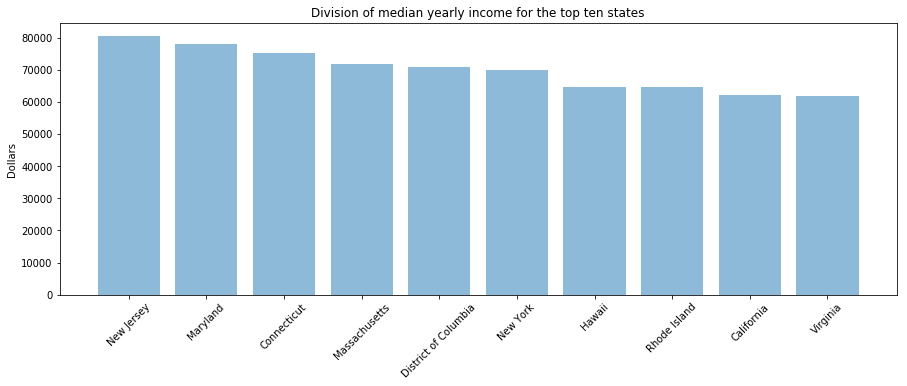

In [20]:
# Create the labels
Labels = (largest_median_income_by_state['Geographic Area'].tolist())
y_pos = np.arange(len(Labels))
# Get the value of median income for each state
performance = largest_median_income_by_state['Median Income'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Labels, rotation=45)
plt.ylabel('Dollars')
plt.title('Division of median yearly income for the top ten states')
 
plt.show()

From the bar plot above we can see that the top ten states with the highest yearly median income ranges from 80.000 to 60.000 dollars where New Jersey has the highest and Virginia is the lowest of the top ten states.

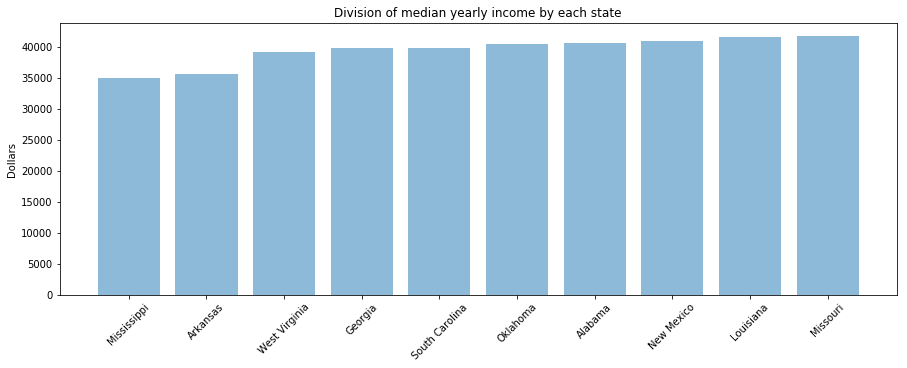

In [21]:
# Create the labels
Labels = (smallest_median_income_by_state['Geographic Area'].tolist())
y_pos = np.arange(len(Labels))
# Get the value of median income for each city
performance = smallest_median_income_by_state['Median Income'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Labels, rotation=45)
plt.ylabel('Dollars')
plt.title('Division of median yearly income by each state')
 
plt.show()

The bar plot above shows us the ten lowest states regarding median yearly income. The lowest states range from 41.000 down to 35.000 dollars.
By comparing the two plots we can see that there is significant difference between the top ten and lowest ten states regarding median yearly income.

#### 4.3.2 Is it better to live in a place with higher income

TODO describe ... notum shootings og median income ...

In [47]:
rr = shootings_df.sort_values(by=['state'], ascending=True)
rs = median_income_by_state.sort_values(by=['Geographic Area'],ascending=True)
print(len(rr['state'].value_counts().tolist()))
print(len(rs['Median Income'].tolist()))

51
51


In [54]:
rr['state'].value_counts().sort_index()

Alabama                  50
Alaska                   15
Arizona                 118
Arkansas                 26
California              424
Colorado                 74
Connecticut               9
Delaware                  8
District of Columbia     11
Florida                 154
Georgia                  70
Hawaii                   11
Idaho                    17
Illinois                 62
Indiana                  43
Iowa                     12
Kansas                   24
Kentucky                 43
Louisiana                57
Maine                    13
Maryland                 38
Massachusetts            22
Michigan                 37
Minnesota                32
Mississippi              23
Missouri                 64
Montana                  11
Nebraska                 15
Nevada                   42
New Hampshire             7
New Jersey               35
New Mexico               51
New York                 45
North Carolina           69
North Dakota              4
Ohio                

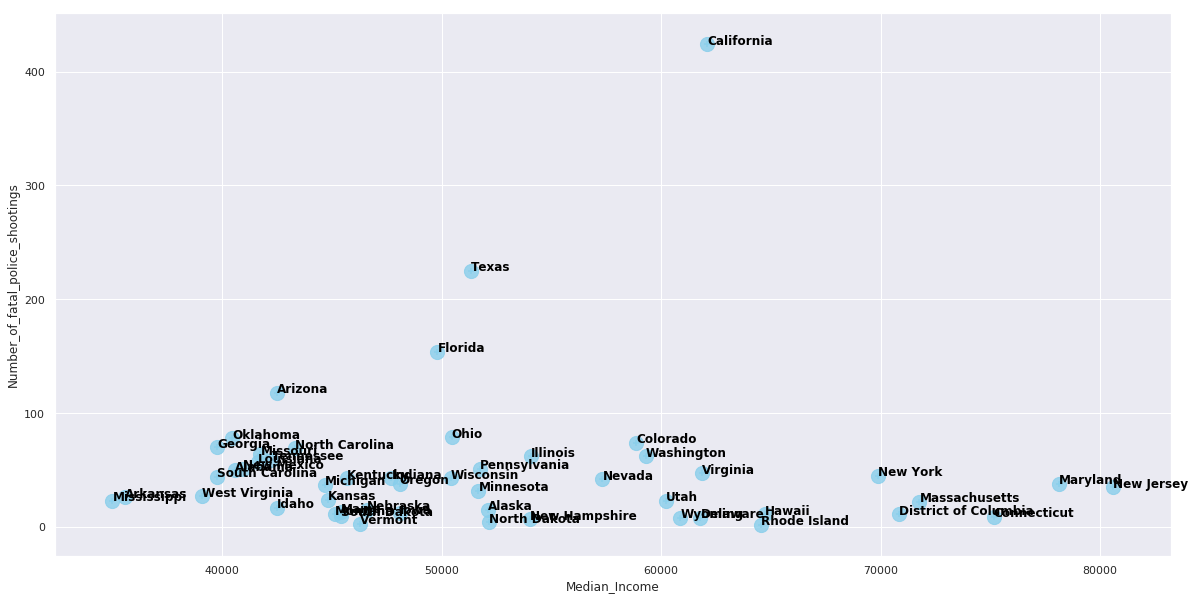

In [56]:

# Create dataframe
df = pd.DataFrame({
'Median_Income': rs['Median Income'].tolist(),
'Number_of_fatal_police_shootings': rr['state'].value_counts().sort_index().tolist(),
'group': rr['state'].value_counts().sort_index().index.tolist()
})
sns.set(rc={'figure.figsize':(20,10)})
 
sns.regplot(data=df, x="Median_Income", y="Number_of_fatal_police_shootings", fit_reg=False, marker="+", color="skyblue")
# basic plot
p1=sns.regplot(data=df, x="Median_Income", y="Number_of_fatal_police_shootings", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})

# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p1.text(df.Median_Income[line]+0.2, df.Number_of_fatal_police_shootings[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')




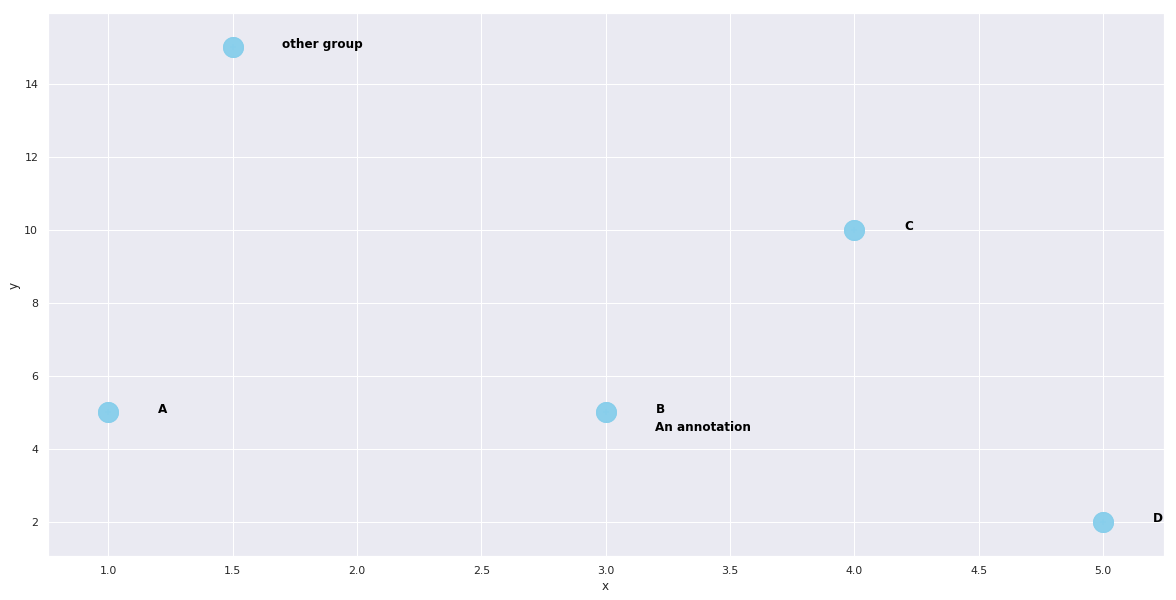

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
 
# Create dataframe
df = pd.DataFrame({
'x': [1, 1.5, 3, 4, 5],
'y': [5, 15, 5, 10, 2],
'group': ['A','other group','B','C','D']
})
 
sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="+", color="skyblue")
#sns.plt.show()
# basic plot
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add text annotation
p1.text(3+0.2, 4.5, "An annotation", horizontalalignment='left', size='medium', color='black', weight='semibold')
#sns.plt.show()
# basic plot
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 
# see it
#sns.plt.show()




about results from 4.3.2

# 4.4 Police shootings with poverty levels

In this chapter we will go povertyLevel data frame. But what is poverty?
Poverty is about not having enough money to meet basic needs including food, clothing and shelter.  
povertyLevel dataframe provides poverty_rate for each city in the United States. The poverty_rate describes how many percentages of people in the corrosponding state are below poverty level. 
Here below you can see the first 10 lines in the dataframe for better understanding of what data we got.

In [25]:
povertyLevel_df.head(10)

,Geographic Area,City,poverty_rate
0,AL,Abanda CDP,78.8
1,AL,Abbeville city,29.1
2,AL,Adamsville city,25.5
3,AL,Addison town,30.7
4,AL,Akron town,42
5,AL,Alabaster city,11.2
6,AL,Albertville city,26.7
7,AL,Alexander City city,30.4
8,AL,Alexandria CDP,9.7
9,AL,Aliceville city,41.3


## 4.4.1 Where is the highest poverty rate

In [26]:
#povertyLevel_df['poverty_rate'] = povertyLevel_df['poverty_rate'].apply(lambda x: x if str(x).isdigit() else None)
#povertyLevel_df.dropna(inplace=True)
#povertyLevel_df['poverty_rate'] = povertyLevel_df['poverty_rate'].apply(lambda x : float(x))

#povertyLevel_df.head(10)

In [27]:
# Change abbreviations of states to state names
# TODO!!!!!!!
'''
#statePovertyLevel_df = povertyLevel_df['Geographic Area'](lambda x : states[x])

print(len(states_shootings_df.value_counts()))
# Create the labels
Labels = states_shootings_df.value_counts().index.tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = states_shootings_df.value_counts().tolist()
# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='gray')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Nr. of deaths')
plt.title('State division of people in fatal police shootings in the US')
 
plt.show()
'''

"\n#statePovertyLevel_df = povertyLevel_df['Geographic Area'](lambda x : states[x])\n\nprint(len(states_shootings_df.value_counts()))\n# Create the labels\nLabels = states_shootings_df.value_counts().index.tolist()\ny_pos = np.arange(len(Labels))\n# Get the values of how many were killed of each gender\nperformance = states_shootings_df.value_counts().tolist()\n# Create the bar plot\nplt.figure(figsize = (15, 8))\nplt.bar(y_pos, performance, align='center', alpha=0.5, color='gray')\nplt.xticks(y_pos, Labels, rotation=90)\nplt.ylabel('Nr. of deaths')\nplt.title('State division of people in fatal police shootings in the US')\n \nplt.show()\n"

TODO: talk about the result

# 5.0 (results) Where to live to avoid fatal police shooting

### 4.1 Visulation of police shootings sorted by races 

To show the difference between the races that are killed in police shootings from the data set we have desided to plot a pie chart which shows the percentages of each race involved in fatal police shootings.

In [28]:
# show the first 10 rows in the data frame
shootings_df['race'].value_counts()

W    1201
B     618
H     423
A      39
N      31
O      28
Name: race, dtype: int64

#### 4.1.1 Diving deeper into the race distribution

As you can see from the pie chart above, the largest percentages of races involved in police shootings had white skin. The results may be surprising, but it makes sense because 61% of people living in the United States in the year 2017 have white skin according to [KFF Population Distribution by Race/Ethnicity](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)

## Reikna út eithvað fjör svipað og hér  ..... [héééééééér...](https://www.vox.com/identities/2016/8/13/17938186/police-shootings-killings-racism-racial-disparities)

## 4.2 Visulation of police shootings, weapons

#### 4.2.1 All Weapons

<BarContainer object of 10 artists>

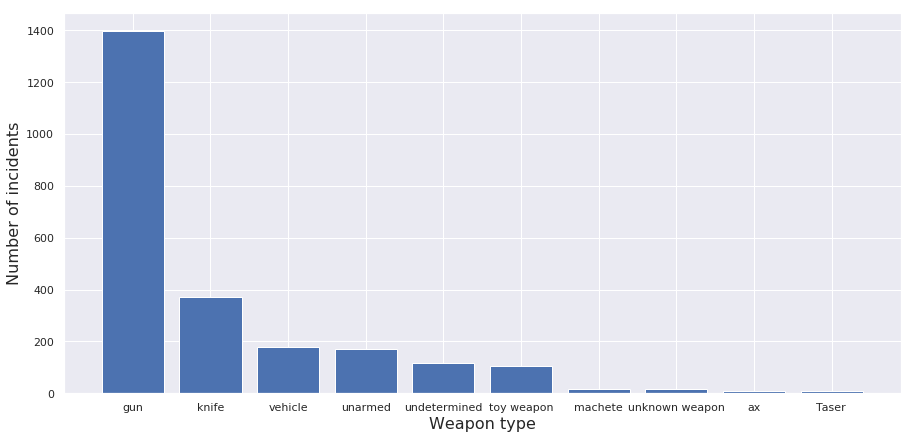

In [29]:
values = shootings_df['armed'].value_counts().values[:10]
labels = shootings_df['armed'].value_counts().index.tolist()[:10]

mpl_fig = plt.figure(figsize = (15, 7))
ax = mpl_fig.add_subplot(111)

ax.set_ylabel("Number of incidents", fontsize=16)
ax.set_xlabel("Weapon type", fontsize=16)

plt.bar(labels, values)

#### Weapons sorted by age gap

(18, 36]    1299
(36, 54]     791
(54, 72]     241
(0, 18]      105
(72, 90]      21
Name: age, dtype: int64
(2535, 12)


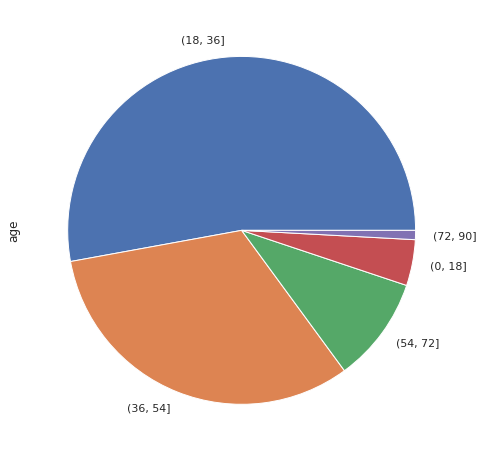

In [30]:
ranges = [i for i in range(0,100,18)]
#rangesLabels = [str(i) + '-' + str(i+10) for i in range(-25,35,10)]
r=range(1,19)
binCounter = pd.cut(shootings_df['age'],ranges).value_counts()
print(binCounter)

#values = shootings_df[shootings_df['age'] ==].value_counts().values[:10]
labels = shootings_df['armed'].value_counts().index.tolist()[:10]
print(shootings_df.shape)


binCounter.plot.pie(figsize=(8, 8))

In [31]:
shootings_df.head(10)

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,2015-02-01,shot,gun,53.0,M,A,Shelton,Washington,True,attack,Not fleeing,False
1,2015-02-01,shot,gun,47.0,M,W,Aloha,Oregon,False,attack,Not fleeing,False
2,2015-03-01,shot and Tasered,unarmed,23.0,M,H,Wichita,Kansas,False,other,Not fleeing,False
3,2015-04-01,shot,toy weapon,32.0,M,W,San Francisco,California,True,attack,Not fleeing,False
4,2015-04-01,shot,nail gun,39.0,M,H,Evans,Colorado,False,attack,Not fleeing,False
5,2015-04-01,shot,gun,18.0,M,W,Guthrie,Oklahoma,False,attack,Not fleeing,False
6,2015-05-01,shot,gun,22.0,M,H,Chandler,Arizona,False,attack,Car,False
7,2015-06-01,shot,gun,35.0,M,W,Assaria,Kansas,False,attack,Not fleeing,False
8,2015-06-01,shot,unarmed,34.0,F,W,Burlington,Iowa,False,other,Not fleeing,True
9,2015-06-01,shot,toy weapon,47.0,M,B,Knoxville,Pennsylvania,False,attack,Not fleeing,False


## 4.3 Visulation of police shootings sorted by age

Lets take a better look at the age distribution

      age
25.0  103
36.0   91
31.0   85
29.0   83
24.0   83
33.0   78
32.0   75
35.0   74
34.0   74
30.0   74


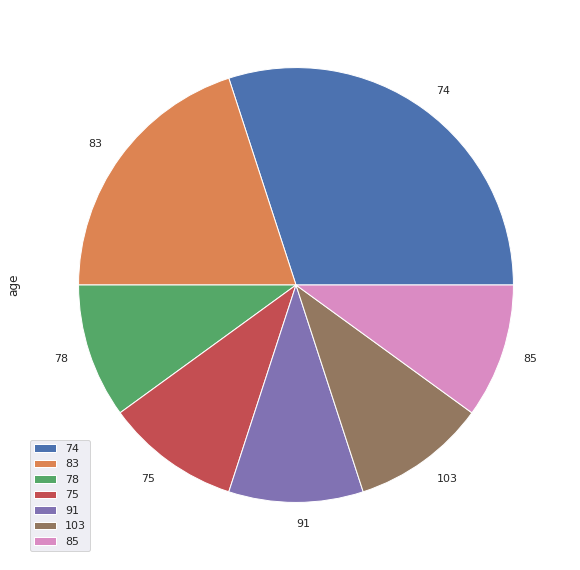

In [32]:
#### TODO ####


# Age rates
values = shootings_df['age'].value_counts()

# Get the 10 most
b = pd.DataFrame(values.head(10))
b.apply(pd.value_counts).plot.pie(subplots=True)
print(b)

4.3 Visulation of police shootings poverty level for each state

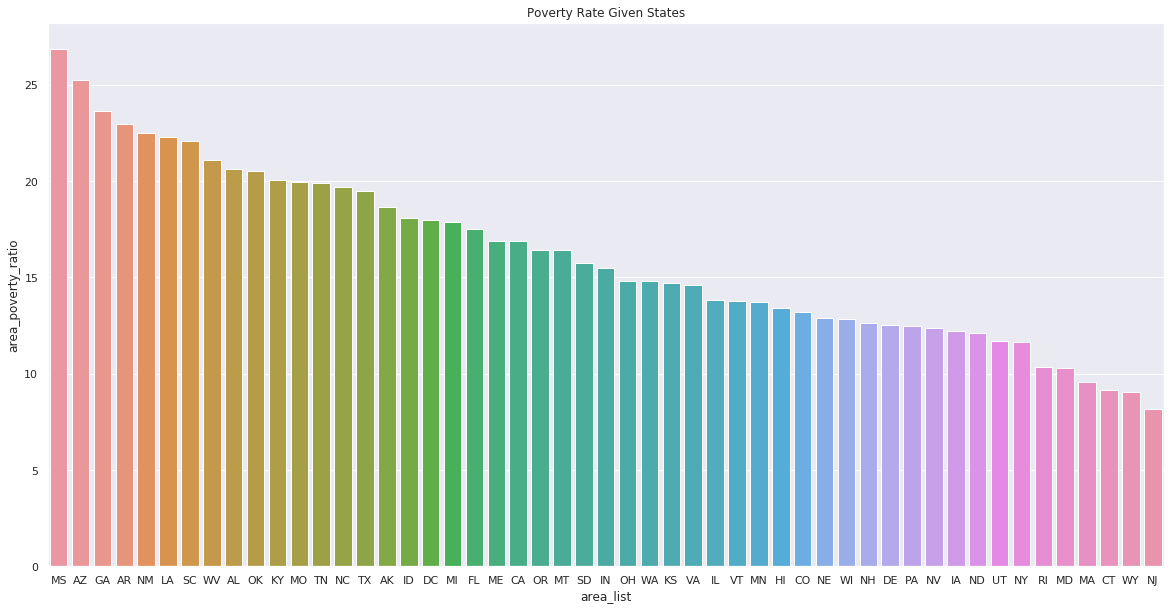

In [33]:
import seaborn as sns

#in order to change '-' to '0'
povertyLevel_df.poverty_rate.replace(['-'],0.0,inplace = True)
#Change the data to float
povertyLevel_df.poverty_rate = povertyLevel_df.poverty_rate.astype(float)
#list of geographic area
area_list = list(povertyLevel_df['Geographic Area'].unique())
area_poverty_ratio = []

for i in area_list:
    #a : geographical area in the i index of the data frame
    a = povertyLevel_df[povertyLevel_df['Geographic Area']==i] 
    area_poverty_rate = a.poverty_rate.mean()
    area_poverty_ratio.append(area_poverty_rate)

data = pd.DataFrame({'area_list' : area_list,'area_poverty_ratio' : area_poverty_ratio})
new_index = (data['area_poverty_ratio'].sort_values(ascending = False)).index.values
sorted_data = data.reindex(new_index)

#visualization
plt.figure(figsize = (20,10))
sns.barplot(x=sorted_data['area_list'],y=sorted_data['area_poverty_ratio'])
plt.xlabel = ('States')
plt.ylabel = ('Poverty Rate')
plt.title('Poverty Rate Given States')
plt.show()


## 4. Data cleaning

in the police-shootings file, we have attributes that are not relevant to us, when visualating the data:
* we have the name of the person killed,
* we also have some id

so we will start by removing those columns

In [34]:
weapon = shootings_df['armed'].value_counts()
print(weapon)

gun                                 1398
knife                                373
vehicle                              177
unarmed                              171
undetermined                         117
toy weapon                           104
machete                               18
unknown weapon                        18
ax                                     9
Taser                                  9
sword                                  8
baseball bat                           8
hammer                                 7
metal pipe                             7
box cutter                             7
crossbow                               6
hatchet                                6
blunt object                           5
gun and knife                          5
screwdriver                            5
scissors                               3
metal stick                            3
rock                                   3
guns and explosives                    3
beer bottle     

* Mental_ilness vs threat_level vs armed

In [35]:
medianIncome_df['Median Income'] = medianIncome_df['Median Income'].apply(lambda x : int(x))
top_ten_medianIncome = medianIncome_df.nlargest(10, 'Median Income')
low_ten_medianIncome = medianIncome_df.nsmallest(10, 'Median Income')
